한 행에 시계열에 대한 데이터가 다 들어가야한다. <br/>
컬럼3, 6, 9, ~ 240
한 행의 답이 20개의 답이 되어줄 것이다.


In [30]:
%pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb  # LightGBM
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.


In [26]:
df = pd.read_csv("./data/rainfall_train.csv", encoding='utf-8', index_col=False)
df['prob_0'] = 100 - df['rainfall_train.v01']
df['prob_1'] = df['rainfall_train.v01'] - df['rainfall_train.v02']
df['prob_2'] = df['rainfall_train.v02'] - df['rainfall_train.v03']
df['prob_3'] = df['rainfall_train.v03'] - df['rainfall_train.v04']
df['prob_4'] = df['rainfall_train.v04'] - df['rainfall_train.v05']
df['prob_5'] = df['rainfall_train.v05'] - df['rainfall_train.v06']
df['prob_6'] = df['rainfall_train.v06'] - df['rainfall_train.v07']
df['prob_7'] = df['rainfall_train.v07'] - df['rainfall_train.v08']
df['prob_8'] = df['rainfall_train.v08'] - df['rainfall_train.v09']
df['prob_9'] = df['rainfall_train.v09']
df.drop(columns=['rainfall_train.v01',
                 'rainfall_train.v02',
                 'rainfall_train.v03',
                 'rainfall_train.v04',
                 'rainfall_train.v05',
                 'rainfall_train.v06',
                 'rainfall_train.v07',
                 'rainfall_train.v08',
                 'rainfall_train.v09'], inplace=True)
df = df[df['rainfall_train.vv'] >= 0]
df["expected"] = (df["prob_0"] * 0\
                +df["prob_1"] * 10\
                +df["prob_2"] * 20\
                +df["prob_3"] * 30\
                +df["prob_4"] * 40\
                +df["prob_5"] * 50\
                +df["prob_6"] * 60\
                +df["prob_7"] * 70\
                +df["prob_8"] * 80\
                +df["prob_9"] * 90) / 100
df.drop(columns=["prob_0","prob_1","prob_2","prob_3","prob_4","prob_5","prob_6","prob_7","prob_8","prob_9",
                 'Unnamed: 0', 'rainfall_train.fc_year',	'rainfall_train.fc_month',	'rainfall_train.fc_day',	'rainfall_train.fc_hour'
                 ], inplace=True)
df

,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,expected
0,STN001,3,A,5,1,12,0.0,0,0.0
1,STN001,6,A,5,1,15,0.0,0,0.0
2,STN001,9,A,5,1,18,0.0,0,0.0
3,STN001,12,A,5,1,21,0.0,0,0.0
4,STN001,15,A,5,2,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
1457247,STN020,228,C,10,10,9,0.5,3,2.0
1457248,STN020,231,C,10,10,12,0.0,0,3.1
1457249,STN020,234,C,10,10,15,1.9,4,3.1
1457250,STN020,237,C,10,10,18,1.9,4,2.2


In [31]:
df["index"] = df["rainfall_train.dh"] // 12
df["index"].value_counts()
pivot_df = df.pivot_table(index=['rainfall_train.stn4contest', 
                                 'rainfall_train.ef_year', 
                                 'rainfall_train.ef_month', 
                                 'rainfall_train.ef_day', 
                                 'rainfall_train.ef_hour',
                                 'rainfall_train.vv',
                                 'rainfall_train.class_interval'
                                 ],
                          columns='index',
                          values='expected').reset_index()
pivot_df


index,rainfall_train.stn4contest,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,0,1,2,...,11,12,13,14,15,16,17,18,19,20
0,STN001,A,5,1,12,0.0,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,STN001,A,5,1,15,0.0,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,STN001,A,5,1,18,0.0,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,STN001,A,5,1,21,0.0,0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STN001,A,5,2,0,0.0,0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77518,STN020,C,10,10,9,0.5,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.1
77519,STN020,C,10,10,12,0.0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1,NaN
77520,STN020,C,10,10,15,1.9,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1,NaN
77521,STN020,C,10,10,18,1.9,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN


In [34]:

final_df = pivot_df.groupby([
    'rainfall_train.stn4contest', 
    'rainfall_train.ef_year', 
    'rainfall_train.ef_month', 
    'rainfall_train.ef_day', 
    'rainfall_train.ef_hour']).sum().reset_index()


In [35]:
final_df[
    (final_df["rainfall_train.stn4contest"] == 'STN001') &
   	(final_df["rainfall_train.ef_year"] == 'A') &	
    (final_df["rainfall_train.ef_month"] == 8) & 
    (final_df["rainfall_train.ef_day"] == 1) &
    (final_df["rainfall_train.ef_hour"] == 15)
       ]

index,rainfall_train.stn4contest,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,0,1,2,...,11,12,13,14,15,16,17,18,19,20
732,STN001,A,8,1,15,21.3,8,59.2,54.9,50.2,...,37.9,37.6,41.8,43.6,40.5,38.5,30.8,30.8,31.2,0.0


In [36]:
df[(df["rainfall_train.stn4contest"] == 'STN001') &
   	(df["rainfall_train.ef_year"] == 'A') &	
    (df["rainfall_train.ef_month"] == 8) & 
    (df["rainfall_train.ef_day"] == 1) &
    (df["rainfall_train.ef_hour"] == 15)
       ]

,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.vv,rainfall_train.class_interval,expected,index
13275,STN001,234,A,8,1,15,21.3,8,31.2,19
13351,STN001,222,A,8,1,15,21.3,8,30.8,18
13427,STN001,210,A,8,1,15,21.3,8,30.8,17
13503,STN001,198,A,8,1,15,21.3,8,38.5,16
13579,STN001,186,A,8,1,15,21.3,8,40.5,15
13655,STN001,174,A,8,1,15,21.3,8,43.6,14
13731,STN001,162,A,8,1,15,21.3,8,41.8,13
13807,STN001,150,A,8,1,15,21.3,8,37.6,12
13883,STN001,138,A,8,1,15,21.3,8,37.9,11
13959,STN001,126,A,8,1,15,21.3,8,39.7,10


In [ ]:
final_df.columns

Index([           'rainfall_train.ef_year',
                 'rainfall_train.ef_month',
                   'rainfall_train.ef_day',
                  'rainfall_train.ef_hour',
                       'rainfall_train.vv',
           'rainfall_train.class_interval',
                                         0,
                                         1,
                                         2,
                                         3,
                                         4,
                                         5,
                                         6,
                                         7,
                                         8,
                                         9,
                                        10,
                                        11,
                                        12,
                                        13,
                                        14,
                                        15,
                                

In [ ]:
final_df.to_csv("./data/pivot_expected.csv", encoding='utf-8', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5448
[LightGBM] [Info] Number of data points in the train set: 46513, number of used features: 47
[LightGBM] [Info] Start training from score -0.167515
[LightGBM] [Info] Start training from score -4.192130
[LightGBM] [Info] Start training from score -3.758152
[LightGBM] [Info] Start training from score -3.822875
[LightGBM] [Info] Start training from score -3.766481
[LightGBM] [Info] Start training from score -3.568942
[LightGBM] [Info] Start training from score -3.990555
[LightGBM] [Info] Start training from score -4.262852
[LightGBM] [Info] Start training from score -5.202310
[LightGBM] [Info] Start training from score -5.395629
CSI: 0.13196365073093638
H: 334, F: 992, M: 1205, C: 12974


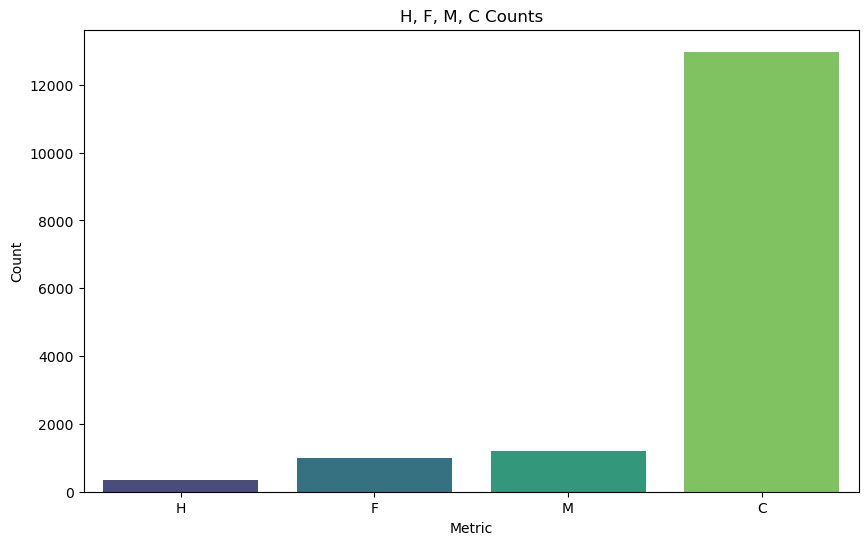

In [37]:
final_df = pd.get_dummies(final_df, columns=['rainfall_train.stn4contest'])
final_df = pd.get_dummies(final_df, columns=['rainfall_train.ef_year'])
final_df

X = final_df.drop(columns=[
    'rainfall_train.vv',
    'rainfall_train.class_interval'
])
y = final_df[['rainfall_train.class_interval']]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42) 

# 개별 모델 학습
catboost = CatBoostClassifier(iterations=100, random_seed=42, silent=True)
lgbm = LGBMClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

catboost.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# 검증 데이터로 개별 모델 예측 (확률 값 사용)
catboost_val_pred_proba = catboost.predict_proba(X_val)
lgbm_val_pred_proba = lgbm.predict_proba(X_val)
xgb_val_pred_proba = xgb.predict_proba(X_val)

# Stacked features for meta model (확률 값 사용)
stacked_features_proba = np.hstack((catboost_val_pred_proba, lgbm_val_pred_proba, xgb_val_pred_proba))
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
meta_model.fit(stacked_features_proba, y_val)

catboost_test_pred_proba = catboost.predict_proba(X_test)
lgbm_test_pred_proba = lgbm.predict_proba(X_test)
xgb_test_pred_proba = xgb.predict_proba(X_test)

stacked_test_features_proba = np.hstack((catboost_test_pred_proba, lgbm_test_pred_proba, xgb_test_pred_proba))
final_pred = meta_model.predict(stacked_test_features_proba)


# # H, F, M, C 계산 함수
# def calculate_csi_components(df):
#     H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
#     F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
#     M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
#     C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
#     return H, F, M, C

# # CSI 계산 함수
# def calculate_csi(H, F, M):
#     return H / (H + F + M) if (H + F + M) > 0 else 0

# # H, F, M, C 계산
# H, F, M, C = calculate_csi_components(results_df)

# # CSI 계산
# csi_value = calculate_csi(H, F, M)
# print(f"CSI: {csi_value}")
# print(f"H: {H}, F: {F}, M: {M}, C: {C}")

# # H, F, M, C 값 시각화
# metrics = pd.DataFrame({'Metric': ['H', 'F', 'M', 'C'], 'Count': [H, F, M, C]})

# plt.figure(figsize=(10, 6))
# sns.barplot(x='Metric', y='Count', data=metrics, palette='viridis')
# plt.title('H, F, M, C Counts')
# plt.xlabel('Metric')
# plt.ylabel('Count')
# plt.show()



In [45]:
display(pd.Series(final_pred).value_counts())
print("hi")
display(len(pd.Series(final_pred)))
print("hello")
display(len(X_test))

0    14179
5      640
6      286
7      106
2       94
3       80
4       64
9       33
8       17
1        6
Name: count, dtype: int64

hi


15505

hello


15505

In [59]:
final_pred_df = pd.DataFrame({'estimated_rank': final_pred})

# 인덱스를 재설정하여 결합
results_df = pd.concat([X_test.reset_index(drop=True), final_pred_df.reset_index(drop=True)], axis=1)
results_df

,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,0,1,2,3,4,5,6,...,rainfall_train.stn4contest_STN015,rainfall_train.stn4contest_STN016,rainfall_train.stn4contest_STN017,rainfall_train.stn4contest_STN018,rainfall_train.stn4contest_STN019,rainfall_train.stn4contest_STN020,rainfall_train.ef_year_A,rainfall_train.ef_year_B,rainfall_train.ef_year_C,estimated_rank
0,8,9,12,50.8,51.1,53.8,54.1,54.3,53.2,41.6,...,False,False,False,False,False,False,False,True,False,5
1,5,26,18,0.0,0.0,0.0,0.2,0.0,0.8,1.8,...,False,False,False,False,False,False,False,False,True,0
2,5,9,0,58.4,41.2,21.8,10.0,17.1,28.6,47.1,...,False,False,False,False,False,False,True,False,False,5
3,6,1,9,0.0,4.4,4.2,3.2,0.7,0.1,0.0,...,False,False,False,False,False,False,True,False,False,0
4,8,7,6,2.2,0.9,1.6,1.1,0.9,2.5,1.9,...,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15500,7,24,18,27.4,12.3,27.7,22.8,19.3,28.0,26.8,...,False,False,True,False,False,False,True,False,False,0
15501,10,9,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,0
15502,9,9,21,0.0,42.3,29.4,29.3,30.3,24.6,26.6,...,False,False,False,False,False,False,True,False,False,0
15503,10,7,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,0


In [60]:
def decode_one_hot(df, prefixes):
    for prefix in prefixes:
        # 원핫 인코딩된 열 목록
        one_hot_cols = [col for col in df.columns if isinstance(col, str) and col.startswith(prefix)]
        
        # 각 행에서 원핫 인코딩된 열이 1인 열 이름을 추출하여 새로운 범주형 열 생성
        df[prefix] = df[one_hot_cols].idxmax(axis=1)
        
        # 열 이름에서 접미사(고유 식별자)만 추출하여 원래 범주형 값을 복원
        df[prefix] = df[prefix].apply(lambda x: x.split('_')[-1])
    
    return df

# 디코딩할 접두사 목록
prefixes = ['rainfall_train.stn4contest', 'rainfall_train.ef_year']

# 인코딩된 데이터프레임에 대해 함수 실행
results_df = decode_one_hot(results_df, prefixes)
results_df

,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,0,1,2,3,4,5,6,...,rainfall_train.stn4contest_STN017,rainfall_train.stn4contest_STN018,rainfall_train.stn4contest_STN019,rainfall_train.stn4contest_STN020,rainfall_train.ef_year_A,rainfall_train.ef_year_B,rainfall_train.ef_year_C,estimated_rank,rainfall_train.stn4contest,rainfall_train.ef_year
0,8,9,12,50.8,51.1,53.8,54.1,54.3,53.2,41.6,...,False,False,False,False,False,True,False,5,STN002,B
1,5,26,18,0.0,0.0,0.0,0.2,0.0,0.8,1.8,...,False,False,False,False,False,False,True,0,STN006,C
2,5,9,0,58.4,41.2,21.8,10.0,17.1,28.6,47.1,...,False,False,False,False,True,False,False,5,STN010,A
3,6,1,9,0.0,4.4,4.2,3.2,0.7,0.1,0.0,...,False,False,False,False,True,False,False,0,STN011,A
4,8,7,6,2.2,0.9,1.6,1.1,0.9,2.5,1.9,...,False,False,False,False,False,False,True,0,STN003,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15500,7,24,18,27.4,12.3,27.7,22.8,19.3,28.0,26.8,...,True,False,False,False,True,False,False,0,STN017,A
15501,10,9,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,0,STN011,C
15502,9,9,21,0.0,42.3,29.4,29.3,30.3,24.6,26.6,...,False,False,False,False,True,False,False,0,STN001,A
15503,10,7,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,False,False,True,0,STN019,C


In [61]:
results_df["estimated_rank"].value_counts()

estimated_rank
0    14179
5      640
6      286
7      106
2       94
3       80
4       64
9       33
8       17
1        6
Name: count, dtype: int64

In [ ]:
ans_df = pd.merge()